<div style="border-top:5px solid DarkRed;"></div><div style="border-top:5px solid Ivory;"></div>
<div style="background-color:DarkRed; color:Ivory; text-align:center; font-family:Share Tech; font-size:44px; margin:0; overflow:hidden; padding:10px 0px 10px 0px;">
PS4E04 [RMSLE] Abalone Age | Submission
</div><div style="border-bottom:5px solid Ivory;"></div><div style="border-bottom:5px solid DarkRed;"></div>
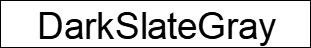
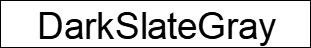
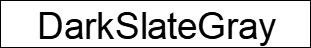
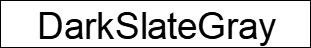
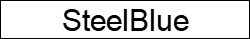
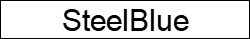
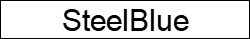
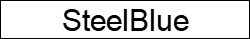

<div style="border-radius:10px;border:5px DarkRed solid;padding:20px;background-color:Ivory;font-size:18px;font-family:'Roboto Condensed', sans-serif;color:DarkSlateGray;display:inline-block">

<table style="border-collapse:collapse;width:100%;text-align:center;table-layout:fixed;">
  <thead>
    <tr>
      <th style="width:100px;border-bottom:2px solid DarkRed;">Model</th>
      <th style="width:100px;border-bottom:2px solid DarkRed;">CV</th>
      <th style="width:100px;border-bottom:2px solid DarkRed;">Public LB</th>
      <th style="width:100px;border-bottom:2px solid DarkRed;">Private LB</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td style="padding:8px;">RAW</td>
      <td style="padding:8px;">14.865</td>
      <td style="padding:8px;"></td>
      <td style="padding:8px;"></td>
    </tr>
    <tr>
      <td style="padding:8px;">FE</td>
      <td style="padding:8px;">14.657</td>
      <td style="padding:8px;"></td>
      <td style="padding:8px;"></td>
    </tr>
  </tbody>
</table>

</div>


# <div style="background-color:DarkRed; color:Ivory; text-align:center; font-family:Share Tech; font-size:40px; margin:0; overflow:hidden; padding:10px 0px 10px 0px;">🥇 01 - Dataset Inspection</div><div style="border-bottom:5px solid Ivory;"></div><div style="border-bottom:5px solid DarkRed;"></div>

## <div style="background-color:Ivory; color:DarkRed; text-align:left; font-family:Share Tech; font-size:28px; margin:0; overflow:hidden; padding: 10px; border-bottom:5px solid DarkRed; border-top:5px solid DarkRed;">🍓 Dataset Importing</div>

In [46]:
#########################
### Library Importing ###
#########################

import pandas   as pd
import numpy    as np
import seaborn  as sns
import matplotlib.pyplot as plt
import lightgbm as lgb
import xgboost  as xgb
import catboost as cat
import re, gc, time, random, optuna, warnings

from matplotlib.ticker  import MaxNLocator
from matplotlib.colors  import LinearSegmentedColormap
from matplotlib.patches import Rectangle
from itertools          import combinations, product
from tqdm.auto          import tqdm
from optuna.samplers    import TPESampler
from optuna.importance  import get_param_importances
from sklearn.impute     import KNNImputer
from sklearn.metrics    import mean_squared_error, r2_score, mean_absolute_error
from sklearn.metrics    import roc_auc_score, accuracy_score, log_loss
from sklearn.metrics    import f1_score, classification_report, confusion_matrix
from sklearn.preprocessing     import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.preprocessing     import LabelEncoder, OneHotEncoder
from sklearn.model_selection   import train_test_split, KFold, StratifiedKFold
from sklearn.feature_selection import mutual_info_classif, mutual_info_regression
warnings.filterwarnings('ignore')

color='DarkRed';line='DarkSlateGray';back='Ivory';edge='Black';seed=42
sns.set(rc = {
'figure.facecolor':back,'axes.facecolor' :back, 'font.family':'Roboto Condensed',
'axes.edgecolor'  :line,'axes.labelcolor':line, 'axes.titlecolor':line,
'xtick.color'     :line,'ytick.color'    :line, 'grid.color'     :line,
'axes.titlesize'  :12,  'axes.labelsize' :8,    'legend.fontsize':8,
'xtick.labelsize' :8,   'ytick.labelsize':8,    'grid.alpha'     :0.1})
def axes_plot(ax):
    ax.spines['right'].set_visible(False); ax.set_xlabel('')
    ax.spines['top'].set_visible(False)  ; ax.set_ylabel('')
    ax.yaxis.set_major_locator(MaxNLocator(nbins=4))
def show_plot(fig, plt):
    fig.patches.append(Rectangle((0,0),1,1,edgecolor=edge, linewidth=2,
                                 transform=fig.transFigure, fill=False))
    plt.tight_layout();plt.show()

In [47]:
#########################
### Dataset Importing ###
#########################

train = pd.read_csv('/kaggle/input/playground-series-s4e4/train.csv')
test  = pd.read_csv('/kaggle/input/playground-series-s4e4/test.csv')
sub   = pd.read_csv('/kaggle/input/playground-series-s4e4/sample_submission.csv')
orig  = pd.read_csv('/kaggle/input/abalone-dataset/abalone.csv')

train = train.drop(['id'],axis =1)
test  = test.drop(['id'],axis =1)
print('train:',train.shape)
print('test :',test.shape)
print('orig :',orig.shape)

train: (90615, 9)
test : (60411, 8)
orig : (4177, 9)


## <div style="background-color:Ivory; color:DarkRed; text-align:left; font-family:Share Tech; font-size:28px; margin:0; overflow:hidden; padding: 10px; border-bottom:5px solid DarkRed; border-top:5px solid DarkRed;">🍒 Feature Checking</div>

In [48]:
#########################
### Feature Checking ####
#########################

column_mapping = {
    'Whole weight': 'Weight',
    'Whole weight.1': 'Shucked',
    'Shucked weight': 'Shucked',
    'Whole weight.2': 'Viscera',
    'Viscera weight': 'Viscera',
    'Shell weight': 'Shell'
}

train.rename(columns=column_mapping, inplace=True)
test.rename(columns=column_mapping, inplace=True)
orig.rename(columns=column_mapping, inplace=True)
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90615 entries, 0 to 90614
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Sex       90615 non-null  object 
 1   Length    90615 non-null  float64
 2   Diameter  90615 non-null  float64
 3   Height    90615 non-null  float64
 4   Weight    90615 non-null  float64
 5   Shucked   90615 non-null  float64
 6   Viscera   90615 non-null  float64
 7   Shell     90615 non-null  float64
 8   Rings     90615 non-null  int64  
dtypes: float64(7), int64(1), object(1)
memory usage: 6.2+ MB


In [49]:
#########################
### Null & Duplicates ###
#########################

target = 'Rings'

print('train null:', train.drop([target], axis=1).isnull().sum().sum())
print('test  null:', test.isnull().sum().sum())
print('orig  null:', orig.drop([target], axis=1).isnull().sum().sum())
print('----- ----- ----- -----')
print('train duplicate:', train.duplicated().sum())
print('test  duplicate:', test.duplicated().sum())
print('orig  duplicate:', orig.duplicated().sum())
print('----- ----- ----- -----')
print('train conflict: ', train.drop([target], axis=1).duplicated().sum())

train null: 0
test  null: 0
orig  null: 0
----- ----- ----- -----
train duplicate: 0
test  duplicate: 0
orig  duplicate: 0
----- ----- ----- -----
train conflict:  0


## <div style="background-color:Ivory; color:DarkRed; text-align:left; font-family:Share Tech; font-size:28px; margin:0; overflow:hidden; padding: 10px; border-bottom:5px solid DarkRed; border-top:5px solid DarkRed;">🍅 Dataset Checking</div>

In [50]:
#########################
### Train & Orig Table ##
#########################

def table(df1, df2, feat, n1='tr', n2='te'):
    df1_d = df1[feat].copy()
    df2_d = df2[feat].copy()
    for col in feat:
        if df1[col].dtype == 'bool':
            df1_d[col] = df1[col].astype(int)
            df2_d[col] = df2[col].astype(int)

    num_feat = df1_d.select_dtypes(include='number').columns.tolist()
    if num_feat:
        df1_desc = df1_d[num_feat].describe().transpose()
        df2_desc = df2_d[num_feat].describe().transpose()

    table = pd.DataFrame(index=feat)
    table['Type']     = df1[feat].dtypes
    table[f'{n1}Nul'] = df1[feat].isnull().sum()
    table[f'{n2}Nul'] = df2[feat].isnull().sum()
    table[f'{n1}Uni'] = df1[feat].nunique()
    table[f'{n2}Uni'] = df2[feat].nunique()

    if num_feat:
        table[f'{n1}Avg'] = df1_desc['mean'].round(1)
        table[f'{n2}Avg'] = df2_desc['mean'].round(1)
        table[f'{n1}Min'] = df1_desc['min'].round(1)
        table[f'{n2}Min'] = df2_desc['min'].round(1)
        table[f'{n1}Max'] = df1_desc['max'].round(1)
        table[f'{n2}Max'] = df2_desc['max'].round(1)

    int_metric = [f'{n1}Nul', f'{n2}Nul', f'{n1}Uni', f'{n2}Uni']
    table[int_metric] = table[int_metric].fillna(0).astype(int)
    table = table.sort_values(by=f'{n1}Uni')
    return table

all_features = train.drop(columns=[target]).columns.tolist()
table(train, orig, all_features, 'tr', 'or')

,Type,trNul,orNul,trUni,orUni,trAvg,orAvg,trMin,orMin,trMax,orMax
Sex,object,0,0,3,3,NaN,NaN,NaN,NaN,NaN,NaN
Height,float64,0,0,90,51,0.1,0.1,0.0,0.0,1.1,1.1
Diameter,float64,0,0,126,111,0.4,0.4,0.1,0.1,0.6,0.6
Length,float64,0,0,157,134,0.5,0.5,0.1,0.1,0.8,0.8
Viscera,float64,0,0,979,880,0.2,0.2,0.0,0.0,0.8,0.8
Shell,float64,0,0,1129,926,0.2,0.2,0.0,0.0,1.0,1.0
Shucked,float64,0,0,1799,1515,0.3,0.4,0.0,0.0,1.5,1.5
Weight,float64,0,0,3175,2429,0.8,0.8,0.0,0.0,2.8,2.8


In [51]:
#########################
### Train & Test Table ##
#########################

train['extra'] = 0
orig['extra']  = 1
test['extra']  = 0
print('raw train:',train.shape)
print('raw orig :',orig.shape)

raw   = len(train) + len(orig)
train = pd.concat([train, orig],axis=0)
check = train.drop(columns=['extra']).columns.tolist()
train.drop_duplicates(subset=check, inplace=True)
new = len(train)

print('----- ----- ----- -----')
print('train_orig duplicate:', raw-new)
print('----- ----- ----- -----')
print('new train:',train.shape)
print('new test :',test.shape)
print('----- ----- ----- -----')

table(train, test, all_features, 'tr', 'te')

raw train: (90615, 10)
raw orig : (4177, 10)
----- ----- ----- -----
train_orig duplicate: 0
----- ----- ----- -----
new train: (94792, 10)
new test : (60411, 9)
----- ----- ----- -----


,Type,trNul,teNul,trUni,teUni,trAvg,teAvg,trMin,teMin,trMax,teMax
Sex,object,0,0,3,3,NaN,NaN,NaN,NaN,NaN,NaN
Height,float64,0,0,90,85,0.1,0.1,0.0,0.0,1.1,1.1
Diameter,float64,0,0,126,130,0.4,0.4,0.1,0.1,0.6,0.6
Length,float64,0,0,157,148,0.5,0.5,0.1,0.1,0.8,0.8
Viscera,float64,0,0,983,960,0.2,0.2,0.0,0.0,0.8,0.6
Shell,float64,0,0,1132,1089,0.2,0.2,0.0,0.0,1.0,1.0
Shucked,float64,0,0,1806,1747,0.3,0.3,0.0,0.0,1.5,1.5
Weight,float64,0,0,3205,3037,0.8,0.8,0.0,0.0,2.8,2.8


  0%|          | 0/7 [00:00<?, ?it/s]

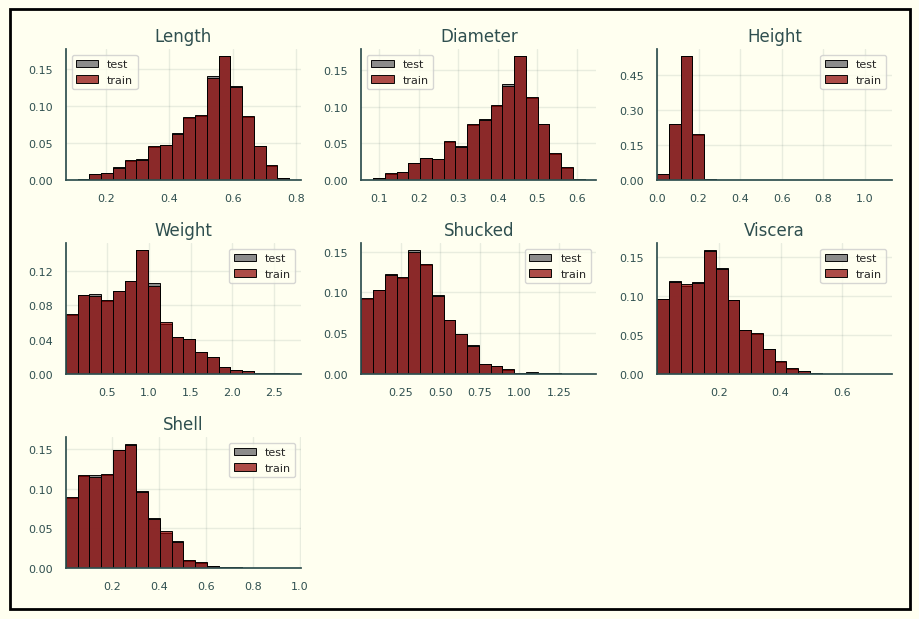

12305

In [52]:
#########################
### Train & Test Plots ##
#########################

features = train.drop(columns=[target, 'extra'])
features = features.select_dtypes(include='number').columns.tolist()
row = int(np.ceil(len(features) / 3))
fig, axes = plt.subplots(row, 3, figsize=(9, row * 2))
axes = axes.flatten()
for i, feature in enumerate(tqdm(features)):
    xmin = min(train[feature].min(), test[feature].min())
    xmax = max(train[feature].max(), test[feature].max())
    bins = np.linspace(xmin, xmax, 21)
    sns.histplot(
        test[feature], ax=axes[i], stat='probability',
        bins=bins, color='gray', edgecolor=edge, alpha=0.9, label='test'
    )
    sns.histplot(
        train[feature], ax=axes[i], stat='probability',
        bins=bins, color=color, edgecolor=edge, alpha=0.7, label='train'
    )
    axes[i].set_xlim(xmin, xmax)
    axes[i].set_title(f'{feature}')
    axes[i].legend()
    axes_plot(axes[i])
for j in range(i + 1, len(axes)): fig.delaxes(axes[j])
show_plot(fig, plt)
gc.collect()

# <div style="background-color:DarkRed; color:Ivory; text-align:center; font-family:Share Tech; font-size:40px; margin:0; overflow:hidden; padding:10px 0px 10px 0px;">🥈 02 - Feature Exploration</div><div style="border-bottom:5px solid Ivory;"></div><div style="border-bottom:5px solid DarkRed;"></div>

## <div style="background-color:Ivory; color:DarkRed; text-align:left; font-family:Share Tech; font-size:28px; margin:0; overflow:hidden; padding: 10px; border-bottom:5px solid DarkRed; border-top:5px solid DarkRed;">🍐 Feature Target</div>

In [53]:
#########################
### Target Checking #####
#########################

train[target].value_counts().sort_index()

Rings
1        26
2        30
3       401
4      1459
5      2977
6      5670
7      9399
8     15067
9     18154
10    13098
11     8894
12     4986
13     4277
14     2633
15     2175
16     1506
17     1233
18      890
19      671
20      533
21      269
22      114
23      189
24       31
25       23
26       19
27       43
29       25
Name: count, dtype: int64

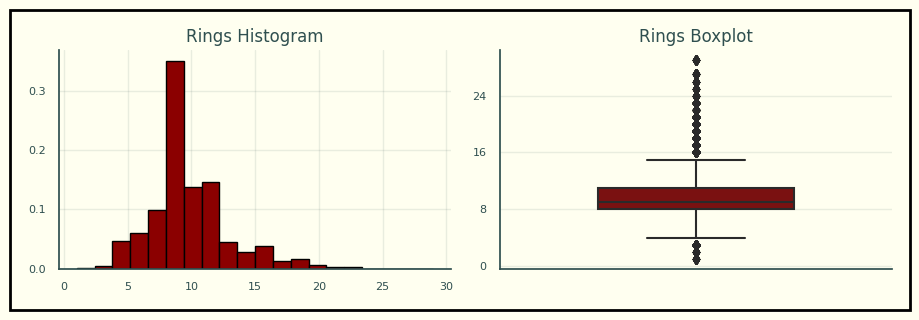

35937

In [54]:
#########################
### Target Plots ########
#########################

fig, axes = plt.subplots(1, 2, figsize=(9, 3))
sns.histplot(train[target], ax=axes[0], stat='probability',
             color=color, edgecolor=edge, bins=20, alpha=1)
axes[0].set_title(f'{target} Histogram')
axes_plot(axes[0])
sns.boxplot(data=train, y=target, ax=axes[1], color=color, width=0.5)
axes[1].set_title(f'{target} Boxplot')
axes_plot(axes[1])
show_plot(fig, plt)
gc.collect()

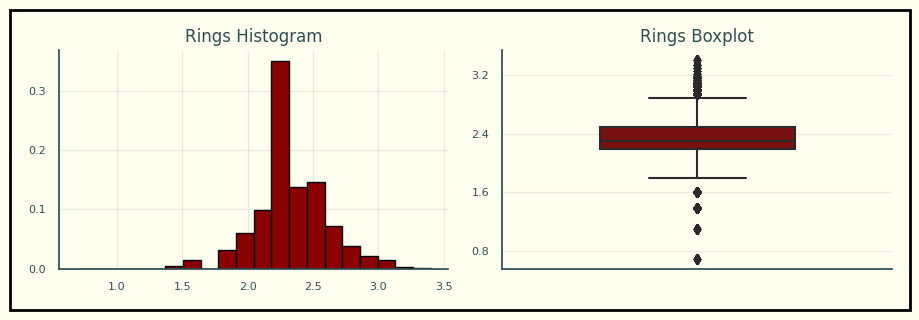

6402

In [55]:
#########################
### log1p Plots #########
#########################

train[target] = np.log1p(train[target])
fig, axes = plt.subplots(1, 2, figsize=(9, 3))
sns.histplot(train[target], ax=axes[0], stat='probability',
             color=color, edgecolor=edge, bins=20, alpha=1)
axes[0].set_title(f'{target} Histogram')
axes_plot(axes[0])
sns.boxplot(data=train, y=target, ax=axes[1], color=color, width=0.5)
axes[1].set_title(f'{target} Boxplot')
axes_plot(axes[1])
show_plot(fig, plt)
gc.collect()

## <div style="background-color:Ivory; color:DarkRed; text-align:left; font-family:Share Tech; font-size:28px; margin:0; overflow:hidden; padding: 10px; border-bottom:5px solid DarkRed; border-top:5px solid DarkRed;">🥝 Feature Category</div>

In [56]:
#########################
### Category Checking ###
#########################

df1 = pd.concat([train, test], axis=0)
cat_features = df1.columns[df1.nunique() <= 20].drop(['extra']).tolist()
cat_features = df1[cat_features].nunique().sort_values().index.tolist()

table(df1[:len(train)], df1[len(train):], cat_features)

,Type,trNul,teNul,trUni,teUni
Sex,object,0,0,3,3


In [57]:
#########################
### Object Encoding #####
#########################
#'''
obj_features = df1.select_dtypes(include='object').columns.tolist()

for col in tqdm(obj_features):
    freq = df1[col].value_counts().sort_values(ascending=False).reset_index()
    freq.columns = ['value', 'rank']
    freq['rank'] = range(len(freq))
    df1[col] = df1[col].map(dict(zip(freq['value'], freq['rank']))).astype(int)

table(df1[:len(train)], df1[len(train):], obj_features)
#'''

  0%|          | 0/1 [00:00<?, ?it/s]

,Type,trNul,teNul,trUni,teUni,trAvg,teAvg,trMin,teMin,trMax,teMax
Sex,int64,0,0,3,3,0.9,0.9,0.0,0.0,2.0,2.0


In [58]:
#########################
### Category Cleaning ###
#########################

'''
def cat_preprocess(df):   
    return df
    
df1 = cat_preprocess(df1)
cat_features = df1.columns[df1.nunique() <= 20].drop([]).tolist()
cat_features = df1[cat_features].nunique().sort_values().index.tolist()
table(df1[:len(train)], df1[len(train):], cat_features)
'''

'\ndef cat_preprocess(df):   \n    return df\n    \ndf1 = cat_preprocess(df1)\ncat_features = df1.columns[df1.nunique() <= 20].drop([]).tolist()\ncat_features = df1[cat_features].nunique().sort_values().index.tolist()\ntable(df1[:len(train)], df1[len(train):], cat_features)\n'

  0%|          | 0/1 [00:00<?, ?it/s]

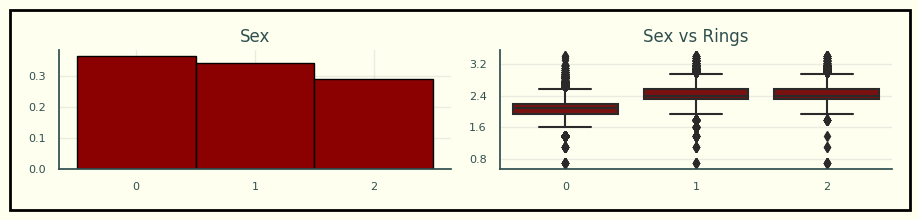

6181

In [59]:
#########################
### Category Plots ######
#########################
#'''
def cat_plot(df, cat_features, target):
    row = len(cat_features)
    fig, axes = plt.subplots(row, 2, figsize=(9, row * 2))
    axes = axes.reshape(-1, 2)
    for i, feature in enumerate(tqdm(cat_features)):
        order = sorted(df[feature].unique())
        xtick = order[::max(1, len(order) // 13)]
        index = [order.index(x) for x in xtick]
        sns.histplot(df[feature], ax=axes[i][0], stat='probability', 
                     color=color, edgecolor=edge, discrete=True, alpha=1)
        axes[i][0].set_xticks(xtick);axes[i][0].set_xticklabels(xtick,ha='center')
        axes[i][0].set_title(f'{feature}')
        axes_plot(axes[i][0])
        sns.boxplot(x=df[feature].astype(str), y=df[target], ax=axes[i][1],
                    color=color, order=[str(x) for x in order])
        axes[i][1].set_xticks(index)
        axes[i][1].set_xticklabels(xtick, ha='center')
        axes[i][1].set_title(f'{feature} vs {target}')
        axes_plot(axes[i][1])
    show_plot(fig, plt)
    
cat_plot(df1, cat_features, target)
gc.collect()
#'''

## <div style="background-color:Ivory; color:DarkRed; text-align:left; font-family:Share Tech; font-size:28px; margin:0; overflow:hidden; padding: 10px; border-bottom:5px solid DarkRed; border-top:5px solid DarkRed;">🥑 Feature Numeric</div>

In [60]:
#########################
### Numeric Checking ####
#########################

df2 = df1.copy()
num_features = df2.columns[df2.nunique() > 20].drop([target]).tolist()
num_features = df2[num_features].nunique().sort_values().index.tolist()

table(df2[:len(train)], df2[len(train):], num_features)

,Type,trNul,teNul,trUni,teUni,trAvg,teAvg,trMin,teMin,trMax,teMax
Height,float64,0,0,90,85,0.1,0.1,0.0,0.0,1.1,1.1
Diameter,float64,0,0,126,130,0.4,0.4,0.1,0.1,0.6,0.6
Length,float64,0,0,157,148,0.5,0.5,0.1,0.1,0.8,0.8
Viscera,float64,0,0,983,960,0.2,0.2,0.0,0.0,0.8,0.6
Shell,float64,0,0,1132,1089,0.2,0.2,0.0,0.0,1.0,1.0
Shucked,float64,0,0,1806,1747,0.3,0.3,0.0,0.0,1.5,1.5
Weight,float64,0,0,3205,3037,0.8,0.8,0.0,0.0,2.8,2.8


In [61]:
#########################
### Numeric Cleaning ####
#########################

#'''
def num_preprocess(df):
    df['Height']   = ((df['Height'] // 0.005).clip(0,60)+1).astype(int)
    df['Diameter'] = (df['Diameter']// 0.005).astype(int)
    df['Length']   = (df['Length']  // 0.005).astype(int)
    df['Viscera']  = (df['Viscera'] // 0.0005).clip(0,1200).astype(int)
    df['Shell']    = (df['Shell']   // 0.0005).astype(int)
    df['Shucked']  = (df['Shucked'] // 0.0005).astype(int)
    df['Weight']   = (df['Weight']  // 0.0005).astype(int)
    return df

df2 = num_preprocess(df2)
num_features = df2[num_features].nunique().sort_values().index.tolist()

table(df2[:len(train)], df2[len(train):], num_features)
#'''

,Type,trNul,teNul,trUni,teUni,trAvg,teAvg,trMin,teMin,trMax,teMax
Height,int64,0,0,50,46,27.6,27.6,1.0,1.0,61.0,61.0
Diameter,int64,0,0,105,103,79.8,79.8,10.0,10.0,130.0,130.0
Length,int64,0,0,129,130,102.9,102.9,14.0,14.0,162.0,160.0
Viscera,int64,0,0,924,909,339.2,338.2,1.0,1.0,1200.0,1200.0
Shell,int64,0,0,1059,1032,452.3,451.7,3.0,3.0,2009.0,2007.0
Shucked,int64,0,0,1555,1517,682.6,681.8,2.0,2.0,2975.0,2975.0
Weight,int64,0,0,2645,2523,1580.9,1579.5,4.0,4.0,5650.0,5650.0


  0%|          | 0/7 [00:00<?, ?it/s]

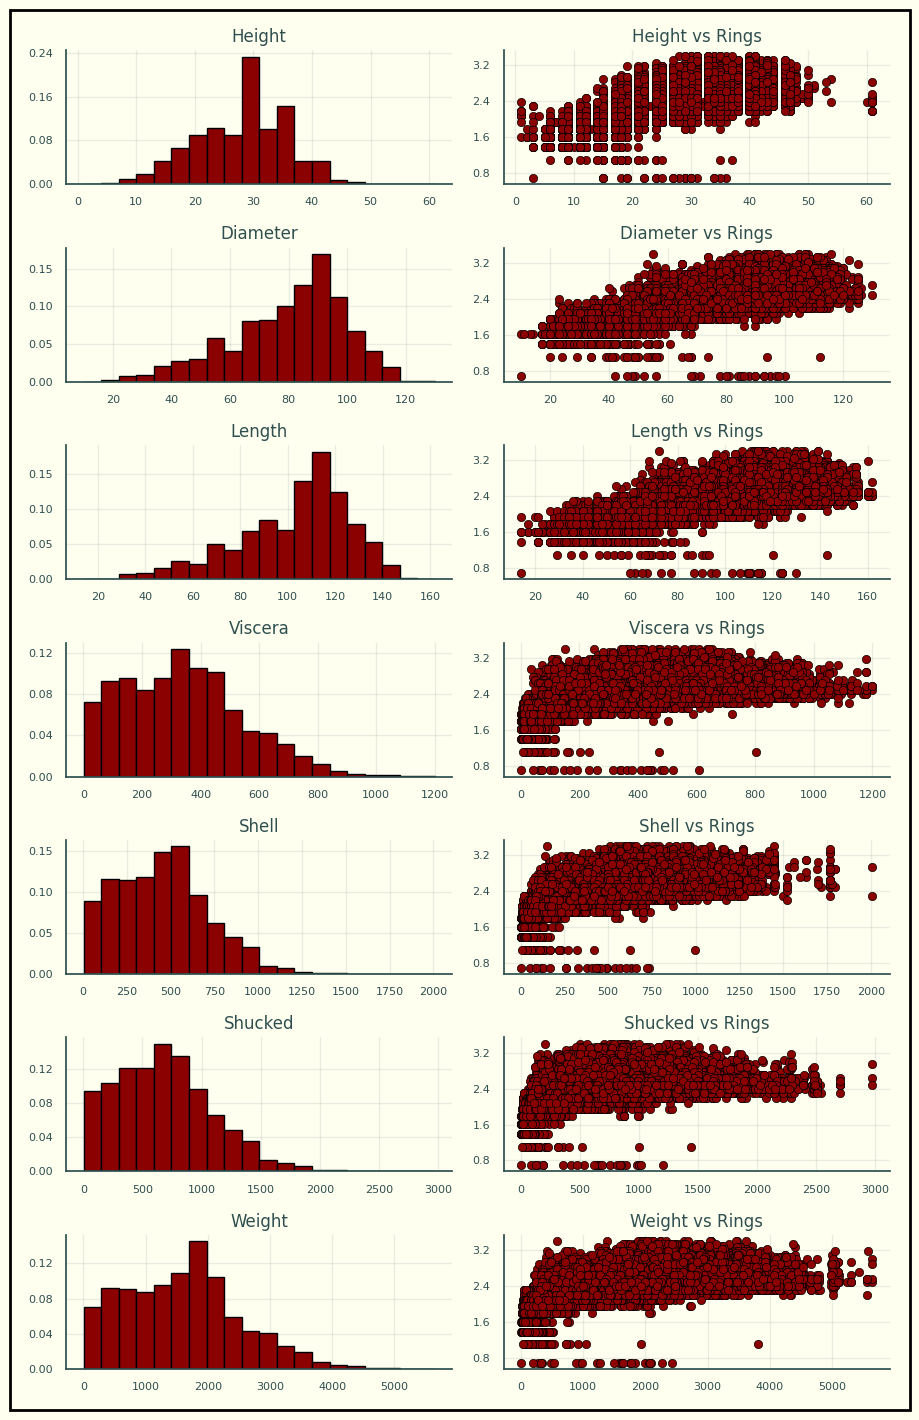

283

In [62]:
#########################
### Numeric Plots #######
#########################

def num_plot(df, num_features, target):
    row = len(num_features)
    fig, axes = plt.subplots(row, 2, figsize=(9, row * 2))
    axes = axes.reshape(-1, 2)
    for i, feature in enumerate(tqdm(num_features)):
        sns.histplot(df[feature], ax=axes[i][0], stat='probability', 
                     color=color, edgecolor=edge, bins=20, alpha=1)
        axes[i][0].set_title(f'{feature}')
        axes_plot(axes[i][0])
        sns.scatterplot(df, x=feature, y=target, ax=axes[i][1], 
                        color=color, edgecolor=edge)
        axes[i][1].set_title(f'{feature} vs {target}')
        axes_plot(axes[i][1])
    show_plot(fig, plt)

num_plot(df2, num_features, target)
gc.collect()

# <div style="background-color:DarkRed; color:Ivory; text-align:center; font-family:Share Tech; font-size:40px; margin:0; overflow:hidden; padding:10px 0px 10px 0px;">🥉 03 - Feature Engineering</div><div style="border-bottom:5px solid Ivory;"></div><div style="border-bottom:5px solid DarkRed;"></div>

## <div style="background-color:Ivory; color:DarkRed; text-align:left; font-family:Share Tech; font-size:28px; margin:0; overflow:hidden; padding: 10px; border-bottom:5px solid DarkRed; border-top:5px solid DarkRed;">🍑 Feature Correlation</div>

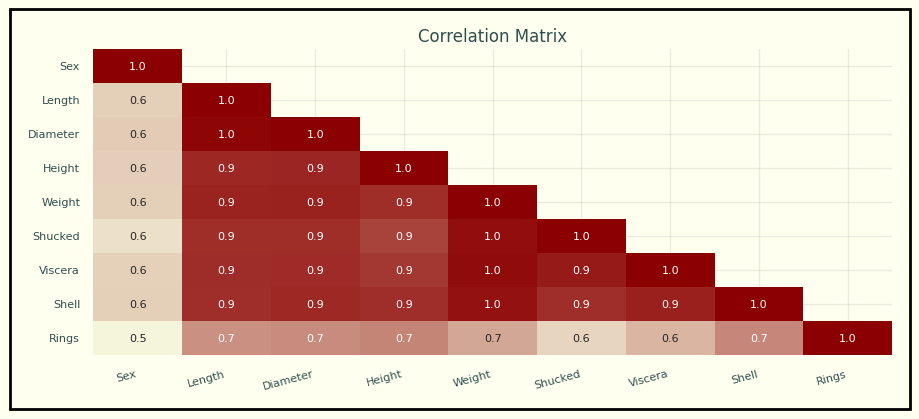

In [63]:
#########################
### Correlation Plots ###
#########################

df3  = df2.copy()
cmap = LinearSegmentedColormap.from_list(None,['Beige',color])
corr = df3.select_dtypes(include=['number']).drop(columns='extra').corr()
cols = [c for c in corr.columns if c != target] + [target]
corr = corr.loc[cols, cols]
mask = np.triu(np.ones_like(corr, dtype=bool), k=1)

fig = plt.figure(figsize=(9, 4))
sns.heatmap(corr, mask=mask, cmap=cmap, cbar=False, annot=True, 
            fmt=".1f", annot_kws={"size": 8})
plt.xticks(rotation=15, ha='right')
plt.tick_params(labelsize=8)
plt.title('Correlation Matrix')
show_plot(fig, plt)

In [64]:
#########################
### Corr & MutualInfo ###
#########################

'''
X = df3.iloc[:len(train)].drop(columns=[target])
Y = df3.iloc[:len(train)][target]

corr = X.corrwith(Y).abs()
info = mutual_info_regression(X, Y, random_state=seed)
info = pd.Series(info, index=X.columns)
corr_info = pd.DataFrame({'Correlation': corr, 'Mutual_Info': info})
corr_info['Avg_Score'] = corr_info.mean(axis=1)
corr_info = corr_info.sort_values(by='Avg_Score', ascending=False)
corr_info.round(4)
'''

"\nX = df3.iloc[:len(train)].drop(columns=[target])\nY = df3.iloc[:len(train)][target]\n\ncorr = X.corrwith(Y).abs()\ninfo = mutual_info_regression(X, Y, random_state=seed)\ninfo = pd.Series(info, index=X.columns)\ncorr_info = pd.DataFrame({'Correlation': corr, 'Mutual_Info': info})\ncorr_info['Avg_Score'] = corr_info.mean(axis=1)\ncorr_info = corr_info.sort_values(by='Avg_Score', ascending=False)\ncorr_info.round(4)\n"

## <div style="background-color:Ivory; color:DarkRed; text-align:left; font-family:Share Tech; font-size:28px; margin:0; overflow:hidden; padding: 10px; border-bottom:5px solid DarkRed; border-top:5px solid DarkRed;">🥭 Feature Encoding</div>

In [65]:
#########################
### Category Encoding ###
#########################

cat_feat = df3.columns[df3.nunique() <= 3000].drop([target]).tolist()
df3[cat_feat] = df3[cat_feat].astype('int32')
cat_feat

['Sex',
 'Length',
 'Diameter',
 'Height',
 'Weight',
 'Shucked',
 'Viscera',
 'Shell',
 'extra']

In [66]:
#########################
### Numeric Encoding ####
#########################

num_feat = df3.columns[df3.nunique() > 3000].drop([]).tolist()

num_feat

[]

In [67]:
#########################
### Train & Test Table ##
#########################

train_all = df3.iloc[:len(train)]
test_all  = df3.iloc[len(train):]
print('train_all', train_all.shape)
print('test_all' , test_all.shape)

table(train_all, test_all, cat_feat+num_feat)

train_all (94792, 10)
test_all (60411, 10)


,Type,trNul,teNul,trUni,teUni,trAvg,teAvg,trMin,teMin,trMax,teMax
extra,int32,0,0,2,1,0.0,0.0,0.0,0.0,1.0,0.0
Sex,int32,0,0,3,3,0.9,0.9,0.0,0.0,2.0,2.0
Height,int32,0,0,50,46,27.6,27.6,1.0,1.0,61.0,61.0
Diameter,int32,0,0,105,103,79.8,79.8,10.0,10.0,130.0,130.0
Length,int32,0,0,129,130,102.9,102.9,14.0,14.0,162.0,160.0
Viscera,int32,0,0,924,909,339.2,338.2,1.0,1.0,1200.0,1200.0
Shell,int32,0,0,1059,1032,452.3,451.7,3.0,3.0,2009.0,2007.0
Shucked,int32,0,0,1555,1517,682.6,681.8,2.0,2.0,2975.0,2975.0
Weight,int32,0,0,2645,2523,1580.9,1579.5,4.0,4.0,5650.0,5650.0


## <div style="background-color:Ivory; color:DarkRed; text-align:left; font-family:Share Tech; font-size:28px; margin:0; overflow:hidden; padding: 10px; border-bottom:5px solid DarkRed; border-top:5px solid DarkRed;">🍉 Feature Generation</div>

In [68]:
#########################
### Feature Interaction #
#########################

fi_base = df3.columns[df3.nunique() >= 10].drop([target]).tolist()
fi_feat = []

combo = list(combinations(fi_base, 2))
for col1, col2 in tqdm(combo):
    feat_mul = f'{col1}_{col2}_mul'
    feat_div = f'{col1}_{col2}_div'
    df3[feat_mul] = df3[col1] * df3[col2]
    df3[feat_div] = df3[col1] / df3[col2]
    fi_feat.extend([feat_mul, feat_div])

gc.collect()

  0%|          | 0/21 [00:00<?, ?it/s]

43960

In [69]:
#########################
### Target Encoding #####
#########################
#'''
import cudf
from cuml.preprocessing import TargetEncoder

df3 = cudf.DataFrame.from_pandas(df3)
te_base = [col for col in cat_feat if col != 'extra']
te_feat = []

combo1 = list(combinations(te_base, 1))
for (col1,) in tqdm(combo1):
    comb = f'combo_{col1}_te'
    df3[comb] = df3[col1].astype(str)
    te_feat.append(comb)

combo2 = list(combinations(te_base, 2))
for col1, col2 in tqdm(combo2):
    comb = f'{col1}_{col2}_te'
    df3[comb] = (df3[col1].astype(str)+'-'+df3[col2].astype(str)).astype(str)
    te_feat.append(comb)

combo3 = list(combinations(te_base, 3))
for col1, col2, col3 in tqdm(combo3):
    comb = f'{col1}_{col2}_{col3}_te'
    df3[comb] = (df3[col1].astype(str)+'-'+df3[col2].astype(str)
                 +'-'+df3[col3].astype(str)).astype(str)
    te_feat.append(comb)

combo4 = list(combinations(te_base, 4))
for col1, col2, col3, col4 in tqdm(combo4):
    comb = f'{col1}_{col2}_{col3}_{col4}_te'
    df3[comb] = (df3[col1].astype(str)+'-'+df3[col2].astype(str)
                 +'-'+df3[col3].astype(str)+'-'+df3[col4].astype(str)).astype(str)
    te_feat.append(comb)

combo5 = list(combinations(te_base, 5))
for col1, col2, col3, col4, col5 in tqdm(combo5):
    comb = f'{col1}_{col2}_{col3}_{col4}_{col5}_te'
    df3[comb] = (df3[col1].astype(str)+'-'+df3[col2].astype(str)
                 +'-'+df3[col3].astype(str)+'-'+df3[col4].astype(str)
                 +'-'+df3[col5].astype(str)).astype(str)
    te_feat.append(comb)

df3 = df3.to_pandas()
for col in tqdm(te_feat):
    labels, _ = pd.factorize(df3[col])
    df3[col] = (labels + 1).astype('int32')
gc.collect()
#'''

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/218 [00:00<?, ?it/s]

57

In [70]:
#########################
### Feature Selection ###
#########################

#'''
new_feat = ['Sex_Shell_te',
 'Weight_Shucked_Shell_te',
 'Diameter_Shell_mul',
 'Height_Shell_mul',
 'Sex_Weight_Shucked_te',
 'combo_Shell_te',
 'Length_Shell_mul',
 'Weight_Shucked_div',
 'Shucked_Shell_div',
 'Weight_Shell_mul',
 'Length_Weight_Shucked_Shell_te',
 'Viscera_Shell_div',
 'Weight_Shucked_Viscera_te',
 'Weight_Shucked_te']

for col in tqdm(te_feat):
    if col not in new_feat:
        df3.drop(columns=[col], inplace=True)
te_feat = [col for col in te_feat if col in new_feat]
gc.collect()

for col in tqdm(fi_feat):
    if col not in new_feat:
        df3.drop(columns=[col], inplace=True)
fi_feat = [col for col in fi_feat if col in new_feat]
gc.collect()
#'''

  0%|          | 0/218 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

20

# <div style="background-color:DarkRed; color:Ivory; text-align:center; font-family:Share Tech; font-size:40px; margin:0; overflow:hidden; padding:10px 0px 10px 0px;">🏆 04 - Model Development</div><div style="border-bottom:5px solid Ivory;"></div><div style="border-bottom:5px solid DarkRed;"></div>

## <div style="background-color:Ivory; color:DarkRed; text-align:left; font-family:Share Tech; font-size:28px; margin:0; overflow:hidden; padding: 10px; border-bottom:5px solid DarkRed; border-top:5px solid DarkRed;">🍍 Cross Validation</div>

In [71]:
#########################
### K-Folds Spliting ####
#########################

def Split(df3, train, n=10, seed=seed, print_info=True):
    Train = df3.iloc[:len(train)]
    Test  = df3.iloc[len(train):].drop(columns=[target])
    tra_x = Train[Train['extra'] == 0].drop(columns=[target])
    tra_y = Train[Train['extra'] == 0][target]
    ext_x = Train[Train['extra'] == 1].drop(columns=[target])
    ext_y = Train[Train['extra'] == 1][target]
    folds, oof_id, oof_true = [], [], []
    kfold = KFold(n_splits=n, shuffle=True, random_state=seed)

    for tr_idx, va_idx in kfold.split(tra_x, tra_y):
        x_train = tra_x.iloc[tr_idx]
        y_train = tra_y.iloc[tr_idx]
        x_valid = tra_x.iloc[va_idx]
        y_valid = tra_y.iloc[va_idx]
        x_train = pd.concat([x_train, ext_x], axis=0).reset_index(drop=True)
        y_train = pd.concat([y_train, ext_y], axis=0).reset_index(drop=True)
        x_test  = Test.copy()

        t = TargetEncoder(n_folds=10, seed=seed, stat='mean')
        for col in tqdm(te_feat):
            x_train[col]=t.fit_transform(x_train[[col]],y_train).astype('float32')
            x_valid[col]=t.transform(x_valid[[col]]).astype('float32')
            x_test[col] =t.transform(x_test[[col]]).astype('float32')
            
        folds.append((x_train, x_valid, y_train, y_valid, x_test, va_idx))
        oof_id.extend(va_idx)
        oof_true.extend(y_valid)
    oof_table = pd.DataFrame({'oof_id': oof_id, 'oof_target': oof_true})
    pred_table = pd.DataFrame()

    if print_info:
        print('x_train', x_train.shape)
        print('x_valid', x_valid.shape)
        print('y_train', y_train.shape)
        print('y_valid', y_valid.shape)
        print('x_test ', x_test.shape)
    return folds, oof_true, oof_table, pred_table

folds, oof_true, oof_table, pred_table = Split(df3, train, n=10)
gc.collect()

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

x_train (85731, 23)
x_valid (9061, 23)
y_train (85731,)
y_valid (9061,)
x_test  (60411, 23)


114

## <div style="background-color:Ivory; color:DarkRed; text-align:left; font-family:Share Tech; font-size:28px; margin:0; overflow:hidden; padding: 10px; border-bottom:5px solid DarkRed; border-top:5px solid DarkRed;">🍌 Model Training</div>

In [72]:
# LGB & XGB & CAT

def Model(model_name, best_param):
    oof, pred, n = [], 0, len(folds)
    for i, (x_train, x_valid, y_train, y_valid, x_test, va_idx) in enumerate(folds):
        if model_name == 'lgb':
            lgb_tr=lgb.Dataset(x_train,y_train,categorical_feature=cat_feat)
            lgb_va=lgb.Dataset(x_valid,y_valid,categorical_feature=cat_feat)
            model=lgb.train(best_param, lgb_tr, 20000, valid_sets=[lgb_va], 
                            callbacks=[lgb.early_stopping(100, verbose=0)])
            oof_f=model.predict(x_valid)
            pred+=model.predict(x_test)/n
            
        elif model_name == 'xgb':
            xgb_tr=xgb.DMatrix(x_train, y_train)
            xgb_va=xgb.DMatrix(x_valid, y_valid)
            model=xgb.train(best_param, xgb_tr, 20000, evals=[(xgb_va,"")],
                            early_stopping_rounds=100, verbose_eval=0)
            oof_f=model.predict(xgb_va)
            pred+=model.predict(xgb.DMatrix(x_test))/n
            
        elif model_name == 'cat':
            cat_tr=cat.Pool(x_train, y_train)#, cat_features=cat_feat)
            cat_va=cat.Pool(x_valid, y_valid)#, cat_features=cat_feat)
            model=cat.train(cat_tr,best_param,eval_set=[cat_va],iterations=20000,
                             early_stopping_rounds=100, verbose=1000)
            oof_f=model.predict(x_valid)
            pred+=model.predict(x_test)/n
                
        metric_fold = mean_squared_error(y_valid, oof_f, squared=False)
        print(f'Fold {i+1}: Metric: {metric_fold:.5f}')
        oof.extend(oof_f)
    metric_overall = mean_squared_error(oof_true, oof, squared=False)
    print(f'Overall Metric: {metric_overall:.5f}')

    return oof, pred

In [73]:
name = 'xgb1'
model = 'xgb'

best_param = {'learning_rate': 0.01, 'max_depth': 6, 
              'reg_alpha': 3.0, 'reg_lambda': 4.57, 'gamma': 0.026, 
              'subsample': 0.75, 'colsample_bytree': 0.52, 
              'colsample_bylevel': 0.72, 'colsample_bynode': 1.0, 
              'max_bin': 1536, 'device': 'cuda', 
              'objective': 'reg:squarederror', 'eval_metric': 'rmse', 
              'random_state': 0}

start = time.time()
oof, pred = Model(model, best_param)
end = time.time()
print(f'Time: {end - start:.2f} seconds')
oof_table[name] = oof
pred_table[name] = pred
sub[target] = pred
sub.to_csv(f'{name}.csv', index=False) 

Fold 1: Metric: 0.14564
Fold 2: Metric: 0.14877
Fold 3: Metric: 0.14485
Fold 4: Metric: 0.14920
Fold 5: Metric: 0.14547
Fold 6: Metric: 0.14479
Fold 7: Metric: 0.14290
Fold 8: Metric: 0.14789
Fold 9: Metric: 0.14373
Fold 10: Metric: 0.14338
Overall Metric: 0.14568
Time: 160.36 seconds


In [74]:
name = 'xgb2'
model = 'xgb'

best_param = {'learning_rate': 0.01, 'max_depth': 12, 
              'reg_alpha': 5.28, 'reg_lambda': 4.07, 'gamma': 0.025, 
              'subsample': 0.65, 'colsample_bytree': 0.89, 
              'colsample_bylevel': 0.93, 'colsample_bynode': 0.33, 
              'max_bin': 1536, 'device': 'cuda', 
              'objective': 'reg:squarederror', 'eval_metric': 'rmse', 
              'random_state': 0}

start = time.time()
oof, pred = Model(model, best_param)
end = time.time()
print(f'Time: {end - start:.2f} seconds')
oof_table[name] = oof
pred_table[name] = pred
sub[target] = pred
sub.to_csv(f'{name}.csv', index=False) 

Fold 1: Metric: 0.14571
Fold 2: Metric: 0.14894
Fold 3: Metric: 0.14494
Fold 4: Metric: 0.14920
Fold 5: Metric: 0.14564
Fold 6: Metric: 0.14495
Fold 7: Metric: 0.14296
Fold 8: Metric: 0.14798
Fold 9: Metric: 0.14384
Fold 10: Metric: 0.14339
Overall Metric: 0.14577
Time: 245.78 seconds


In [75]:
name = 'xgb3'
model = 'xgb'

best_param = {'learning_rate': 0.01, 'max_depth': 18, 
              'reg_alpha': 4.29, 'reg_lambda': 8.96, 'gamma': 0.019, 
              'subsample': 0.83, 'colsample_bytree': 0.9, 
              'colsample_bylevel': 0.39, 'colsample_bynode': 0.6, 
              'max_bin': 256, 'device': 'cuda', 
              'objective': 'reg:squarederror', 'eval_metric': 'rmse', 
              'random_state': 0}

start = time.time()
oof, pred = Model(model, best_param)
end = time.time()
print(f'Time: {end - start:.2f} seconds')
oof_table[name] = oof
pred_table[name] = pred
sub[target] = pred
sub.to_csv(f'{name}.csv', index=False) 

Fold 1: Metric: 0.14586
Fold 2: Metric: 0.14887
Fold 3: Metric: 0.14495
Fold 4: Metric: 0.14899
Fold 5: Metric: 0.14575
Fold 6: Metric: 0.14492
Fold 7: Metric: 0.14290
Fold 8: Metric: 0.14781
Fold 9: Metric: 0.14377
Fold 10: Metric: 0.14324
Overall Metric: 0.14572
Time: 181.18 seconds


In [76]:
name = 'lgb1'
model = 'lgb'

best_param = {'learning_rate': 0.01, 'max_depth': 6, 
              'reg_alpha': 1.24, 'reg_lambda': 1.54, 
              'min_split_gain': 0.018, 'subsample': 0.78, 
              'colsample_bytree': 0.49, 'colsample_bynode': 0.34, 
              'min_child_samples': 0, 'num_leaves': 384, 'max_bin': 768, 
              'objective': 'regression', 'metric': 'rmse', 
              'random_state': 0, 'verbose': -1}

start = time.time()
oof, pred = Model(model, best_param)
end = time.time()
print(f'Time: {end - start:.2f} seconds')
oof_table[name] = oof
pred_table[name] = pred
sub[target] = pred
sub.to_csv(f'{name}.csv', index=False) 

Fold 1: Metric: 0.14738
Fold 2: Metric: 0.15014
Fold 3: Metric: 0.14639
Fold 4: Metric: 0.15017
Fold 5: Metric: 0.14714
Fold 6: Metric: 0.14575
Fold 7: Metric: 0.14421
Fold 8: Metric: 0.14853
Fold 9: Metric: 0.14467
Fold 10: Metric: 0.14369
Overall Metric: 0.14682
Time: 118.09 seconds


In [77]:
name = 'lgb2'
model = 'lgb'

best_param = {'learning_rate': 0.01, 'max_depth': 12, 
              'reg_alpha': 0.17, 'reg_lambda': 2.8, 
              'min_split_gain': 0.043, 'subsample': 0.6, 
              'colsample_bytree': 0.78, 'colsample_bynode': 0.1, 
              'min_child_samples': 42, 'num_leaves': 992, 'max_bin': 1536, 
              'objective': 'regression', 'metric': 'rmse', 
              'random_state': 0, 'verbose': -1}

start = time.time()
oof, pred = Model(model, best_param)
end = time.time()
print(f'Time: {end - start:.2f} seconds')
oof_table[name] = oof
pred_table[name] = pred
sub[target] = pred
sub.to_csv(f'{name}.csv', index=False) 

Fold 1: Metric: 0.14652
Fold 2: Metric: 0.14932
Fold 3: Metric: 0.14575
Fold 4: Metric: 0.14960
Fold 5: Metric: 0.14647
Fold 6: Metric: 0.14541
Fold 7: Metric: 0.14346
Fold 8: Metric: 0.14791
Fold 9: Metric: 0.14391
Fold 10: Metric: 0.14312
Overall Metric: 0.14616
Time: 208.79 seconds


In [78]:
name = 'lgb3'
model = 'lgb'

best_param = {'learning_rate': 0.01, 'max_depth': 18, 
              'reg_alpha': 0.69, 'reg_lambda': 5.63, 
              'min_split_gain': 0.015, 'subsample': 0.49, 
              'colsample_bytree': 0.7, 'colsample_bynode': 0.18, 
              'min_child_samples': 46, 'num_leaves': 1344, 'max_bin': 1280, 
              'objective': 'regression', 'metric': 'rmse', 
              'random_state': 0, 'verbose': -1}

start = time.time()
oof, pred = Model(model, best_param)
end = time.time()
print(f'Time: {end - start:.2f} seconds')
oof_table[name] = oof
pred_table[name] = pred
sub[target] = pred
sub.to_csv(f'{name}.csv', index=False) 

Fold 1: Metric: 0.14655
Fold 2: Metric: 0.14920
Fold 3: Metric: 0.14565
Fold 4: Metric: 0.14977
Fold 5: Metric: 0.14659
Fold 6: Metric: 0.14542
Fold 7: Metric: 0.14359
Fold 8: Metric: 0.14807
Fold 9: Metric: 0.14429
Fold 10: Metric: 0.14328
Overall Metric: 0.14626
Time: 263.41 seconds


In [82]:
name = 'cat1'
model = 'cat'

best_param = {'learning_rate': 0.01, 'max_depth': 6, 
              'reg_lambda': 7.0, 'random_strength': 7.0, 
              'bagging_temperature': 0.6, 'min_child_samples': 36, 
              'task_type': 'GPU', 'objective': 'RMSE', 
              'eval_metric': 'RMSE', 'random_state': 0}

start = time.time()
oof, pred = Model(model, best_param)
end = time.time()
print(f'Time: {end - start:.2f} seconds')
oof_table[name] = oof
pred_table[name] = pred
sub[target] = pred
sub.to_csv(f'{name}.csv', index=False) 

0:	learn: 0.2834536	test: 0.2867907	best: 0.2867907 (0)	total: 8.82ms	remaining: 2m 56s
1000:	learn: 0.1481791	test: 0.1487674	best: 0.1487674 (999)	total: 5.63s	remaining: 1m 46s
2000:	learn: 0.1458122	test: 0.1472686	best: 0.1472686 (2000)	total: 12.3s	remaining: 1m 50s
3000:	learn: 0.1442253	test: 0.1466648	best: 0.1466648 (3000)	total: 18.8s	remaining: 1m 46s
4000:	learn: 0.1429909	test: 0.1463487	best: 0.1463487 (4000)	total: 25.3s	remaining: 1m 41s
5000:	learn: 0.1419060	test: 0.1461697	best: 0.1461673 (4978)	total: 31.6s	remaining: 1m 34s
6000:	learn: 0.1409094	test: 0.1460428	best: 0.1460427 (5999)	total: 36.8s	remaining: 1m 25s
7000:	learn: 0.1399804	test: 0.1459668	best: 0.1459661 (6995)	total: 42.3s	remaining: 1m 18s
bestTest = 0.1458857193
bestIteration = 7857
Shrink model to first 7858 iterations.
Fold 1: Metric: 0.14589
0:	learn: 0.2836062	test: 0.2853966	best: 0.2853966 (0)	total: 8.64ms	remaining: 2m 52s
1000:	learn: 0.1477419	test: 0.1521122	best: 0.1521120 (999)	total

## <div style="background-color:Ivory; color:DarkRed; text-align:left; font-family:Share Tech; font-size:28px; margin:0; overflow:hidden; padding: 10px; border-bottom:5px solid DarkRed; border-top:5px solid DarkRed;">🌽 Model Blending</div>

In [86]:
oof_table

,oof_id,oof_target,xgb1,xgb2,xgb3,lgb1,lgb2,lgb3,cat1,cat2
0,102,1.945910,2.028765,2.027260,2.030259,2.010208,2.029926,2.015159,2.039999,2.043194
1,103,2.639057,2.592855,2.597132,2.588579,2.590586,2.604461,2.602047,2.597565,2.596543
2,106,2.302585,2.371296,2.370614,2.375844,2.396267,2.391554,2.384930,2.375003,2.379766
3,124,3.135494,2.892439,2.883617,2.875169,2.863907,2.854736,2.846689,2.885562,2.889511
4,127,2.197225,2.296412,2.288189,2.295095,2.316415,2.316937,2.318107,2.299442,2.291497
...,...,...,...,...,...,...,...,...,...,...
90610,90568,2.302585,2.494322,2.485863,2.484835,2.507913,2.507887,2.524120,2.491441,2.489164
90611,90578,2.833213,2.589462,2.600403,2.588842,2.632557,2.636563,2.625184,2.587648,2.591271
90612,90594,2.564949,2.673942,2.694115,2.684554,2.622448,2.652528,2.634425,2.691261,2.712886
90613,90597,2.639057,2.614150,2.599879,2.605658,2.572934,2.584243,2.580282,2.583268,2.580890


In [84]:
#########################
### Hill Climbers #######
#########################

!pip install -q hillclimbers
from hillclimbers import climb_hill, partial

hc_test, hc_oof = climb_hill(
    train            = oof_table,
    target           = 'oof_target',
    oof_pred_df      = oof_table.drop(columns=['oof_id','oof_target']),
    test_pred_df     = pred_table,
    precision        = 0.001,
    objective        = 'minimize',
    eval_metric      = partial(mean_squared_error, squared=False),
    plot_hill        = False, 
    plot_hist        = False, 
    negative_weights = True,
    return_oof_preds = True)

sub[target] = np.expm1(hc_test)
sub.to_csv("submission_test.csv",index=False)

   /\  
  /__\  hillclimbers 
 /    \
/______\ 

Models to be ensembled | (7 total): 

xgb1: 0.14568 (best solo model)
xgb3: 0.14572
xgb2: 0.14577
cat1: 0.14597
lgb2: 0.14616
lgb3: 0.14626
lgb1: 0.14682

[Data preparation completed successfully] - [Initiate hill climbing] 

Iteration: 1 | Model added: lgb3 | Best weight: 0.366 | Best mean_squared_error: 0.14539
Iteration: 2 | Model added: xgb3 | Best weight: 0.187 | Best mean_squared_error: 0.14537
Iteration: 3 | Model added: lgb2 | Best weight: 0.070 | Best mean_squared_error: 0.14536
Iteration: 4 | Model added: cat1 | Best weight: 0.090 | Best mean_squared_error: 0.14536
Iteration: 5 | Model added: xgb2 | Best weight: -0.069 | Best mean_squared_error: 0.14535
Iteration: 6 | Model added: lgb1 | Best weight: -0.043 | Best mean_squared_error: 0.14535
